In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [52]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=5

In [6]:
import io
%cd C:\Users\savit\Desktop\Datasets

C:\Users\savit\Desktop\Datasets


In [7]:
dataset= tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256, 256),
    batch_size=BATCH_SIZE)


Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 2 1 0 1 1 0 2 1 0 1 2]


In [10]:
# Visualize some of the images from our dataset

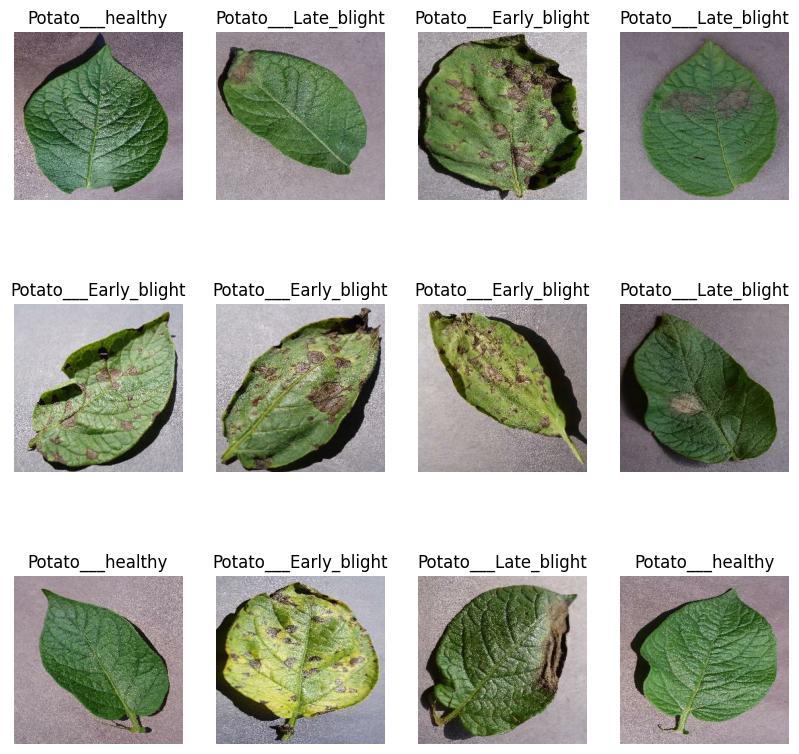

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
#Function to Split Dataset

# Dataset should be bifurcated into 3 subsets, namely:

    # Training: Dataset to be used while training
    # Validation: Dataset to be tested against while training
    # Test: Dataset to be tested against after we trained a model 



In [13]:
len(dataset)

68

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [25]:
# Cache, Shuffle, and Prefetch the Dataset

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
# Building the Model

In [28]:
# 
# Creating a Layer for Resizing and Normalization

# Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

# You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it


In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [30]:
# Data Augmentation

# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.


In [31]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
# Applying Data Augmentation to Train Dataset

In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
# Model Architecture

# We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

# We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [37]:
# Compiling the Model

# We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric


In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
54/54 [==============================] - 204s 4s/step - loss: 0.2026 - accuracy: 0.9155 - val_loss: 0.2348 - val_accuracy: 0.9219
Epoch 2/5
54/54 [==============================] - 212s 4s/step - loss: 0.1722 - accuracy: 0.9311 - val_loss: 0.2290 - val_accuracy: 0.9271
Epoch 3/5
54/54 [==============================] - 207s 4s/step - loss: 0.1462 - accuracy: 0.9427 - val_loss: 0.1629 - val_accuracy: 0.9323
Epoch 4/5
54/54 [==============================] - 194s 4s/step - loss: 0.1301 - accuracy: 0.9525 - val_loss: 0.1356 - val_accuracy: 0.9583
Epoch 5/5
54/54 [==============================] - 157s 3s/step - loss: 0.1387 - accuracy: 0.9410 - val_loss: 0.1759 - val_accuracy: 0.9271


In [42]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 655ms/step - loss: 0.3707 - accuracy: 0.8633


In [ ]:
#  You can see above that we get about 86.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [43]:
scores

[0.3707497715950012, 0.86328125]

In [ ]:
# Scores is just a list containing loss and accuracy value


In [ ]:
# Plotting the Accuracy and Loss Curves

In [44]:
history

In [45]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch


In [47]:
type(history.history['loss'])

list

In [48]:
len(history.history['loss'])

5

In [49]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.20264208316802979,
 0.17224210500717163,
 0.14620649814605713,
 0.1301388442516327,
 0.1386687159538269]

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

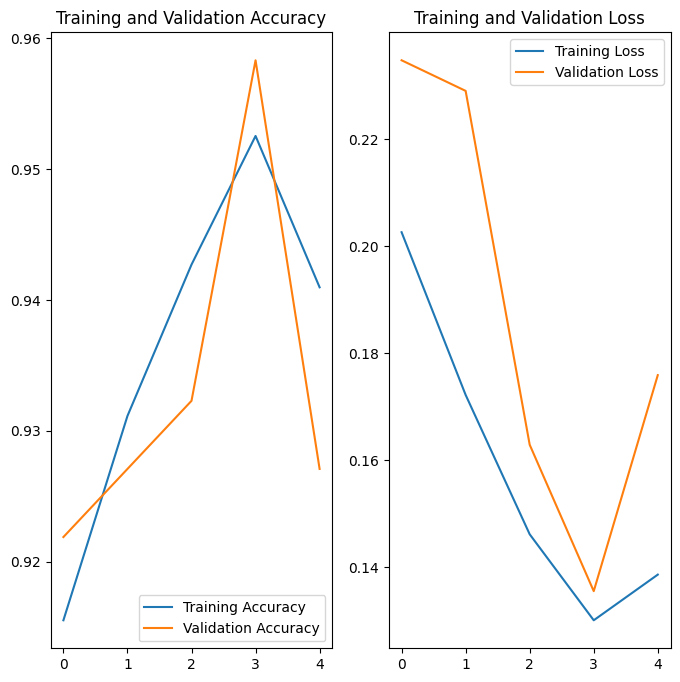

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


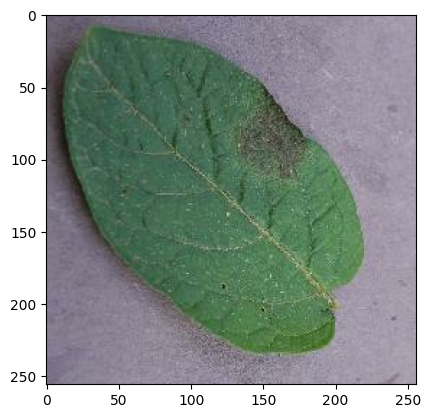

In [54]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
# Write a function for inference

In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
# Now run inference on few sample images:


1/1 [==============================] - 0s 47ms/step


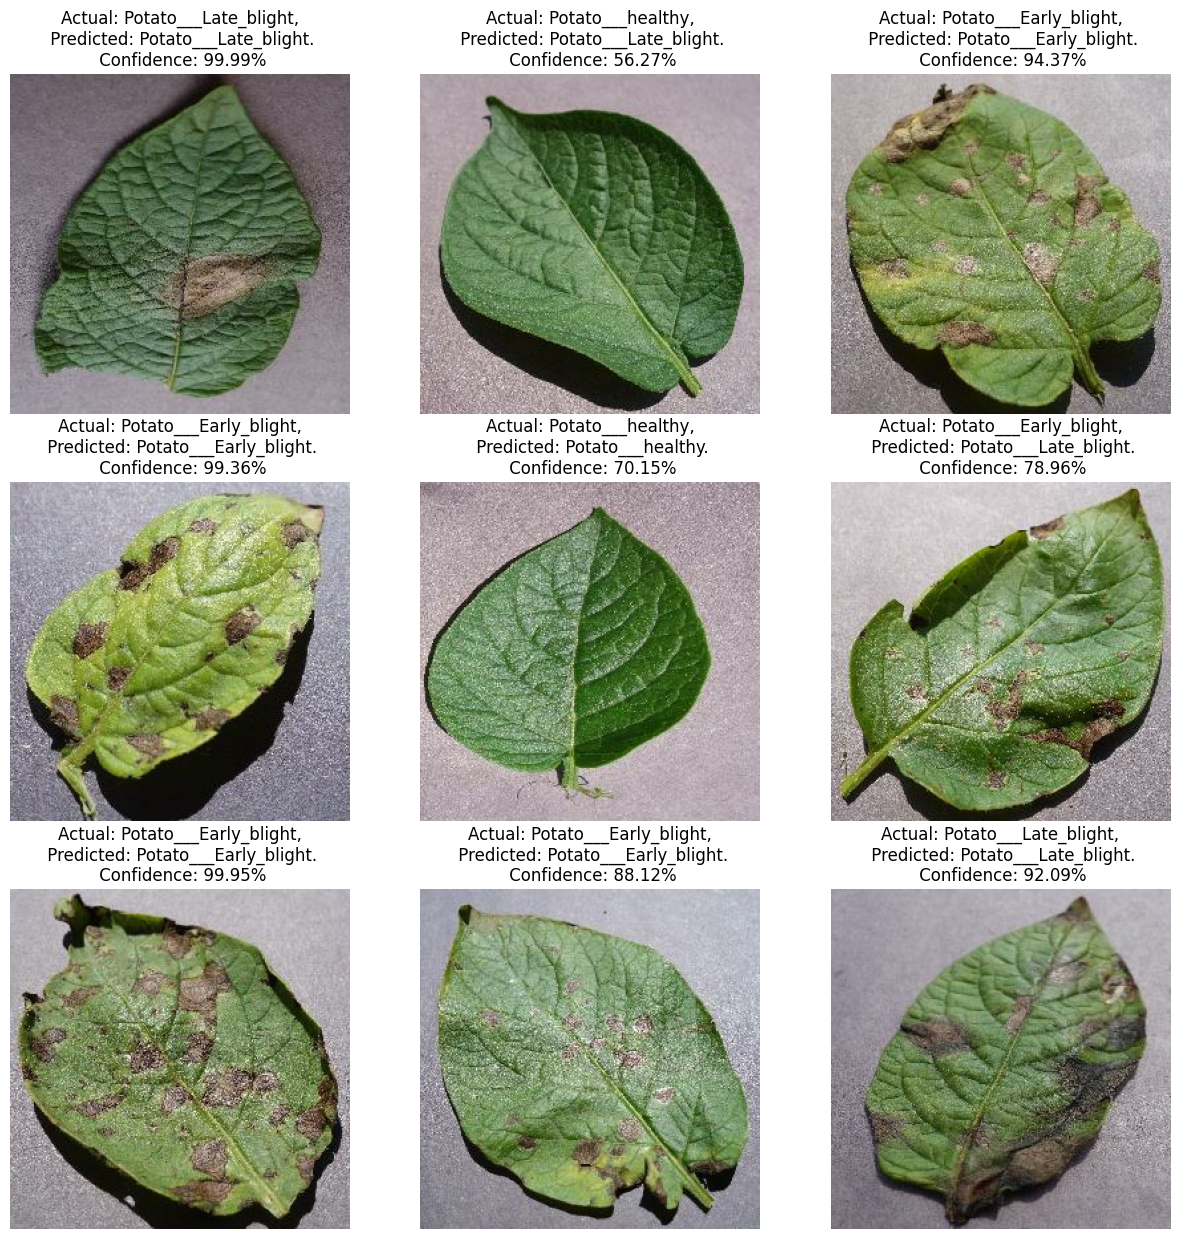

In [57]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")